# Capstone Project Luigi Fiori

In [24]:
from collections import Counter
import requests 
import pickle
import json
import os
import decimal
import hmac
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import itertools


import mplfinance as mpf
import mpl_finance
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import numpy as np

style.use('ggplot')

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, confusion_matrix

import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings

In [2]:
def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [3]:
keys = get_keys("/Users/luigi/.secret/bc_api.json")

api_key = keys['api_key']
secret_key = keys['secret_key']

In [4]:
binance_keys = {
    'api_key': api_key,
    'secret_key': secret_key
}

## Get trading data for BTCUSD

In [5]:
df_btcusd = pd.DataFrame()

for x in range(2):

    if x == 0: 

        response = requests.get(f'https://api.binance.com/api/v1/klines?symbol=BTCUSDT&interval=1d')
        data_symbol = json.loads(response.text)

        # put in dataframe and drop columns we don't neeed
        df = pd.DataFrame.from_dict(data_symbol)
        df = df.drop(range(6, 12), axis=1)

        # rename columns
        col_names = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
        df.columns = col_names

        # transform values from strings to floats
        for col in col_names[1:6]:
            df[col] = df[col].astype(float)

        df = df.sort_values(by='Time', ascending=False)

        df_btcusd = df_btcusd.append(df)

        timestamp = int(df.loc[0, 'Time'])
        
        if len(df) < 499:
            
            break

    else:

        response = requests.get(f'https://api.binance.com/api/v1/klines?symbol=BTCUSDT&interval=1d&endTime={timestamp}')
        data_symbol = json.loads(response.text)

        # put in dataframe and drop columns we don't neeed
        df1 = pd.DataFrame.from_dict(data_symbol)
        df1 = df1.drop(range(6, 12), axis=1)

                # rename columns
        col_names = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
        df1.columns = col_names

        # transform values from strings to floats
        for col in col_names[1:6]:
            df1[col] = df1[col].astype(float)

        timestamp = int(df1.loc[0, 'Time'])
        
        df1 = df1.sort_values(by='Time', ascending=False)

        df1.drop(df1.head(1).index,inplace=True)

        df_btcusd = df_btcusd.append(df1)

        df_btcusd.reset_index(drop = True, inplace = True)




df_btcusd['Date'] = pd.to_datetime(df_btcusd['Time'], unit='ms')

df_btcusd.to_csv('BTCUSDT_df_daily.csv')

In [6]:
df_btcusd

,Time,Open,High,Low,Close,Volume,Date
0,1581984000000,9706.00,9815.00,9576.01,9687.63,31135.781470,2020-02-18
1,1581897600000,9910.70,9964.16,9452.67,9706.00,70261.011901,2020-02-17
2,1581811200000,9904.46,10050.00,9638.12,9917.27,60023.999537,2020-02-16
3,1581724800000,10344.36,10375.00,9801.00,9904.72,57657.202947,2020-02-15
4,1581638400000,10227.78,10381.56,10111.37,10344.36,47038.480173,2020-02-14
5,1581552000000,10325.33,10500.00,10080.00,10229.63,79344.358759,2020-02-13
6,1581465600000,10223.08,10450.00,10223.08,10326.46,61008.063930,2020-02-12
7,1581379200000,9851.74,10323.59,9700.00,10223.08,62422.395224,2020-02-11
8,1581292800000,10151.72,10188.00,9756.00,9851.83,59573.084619,2020-02-10
9,1581206400000,9895.04,10166.00,9880.75,10151.75,43408.475616,2020-02-09


In [7]:
candle = go.Candlestick(
            x = df_btcusd['Date'],
            open = df_btcusd['Open'],
            close = df_btcusd['Close'],
            high = df_btcusd['High'],
            low = df_btcusd['Low'],
            name = "Candlesticks")

fig = go.Figure(data=[candle])

fig.show()

In [8]:
df_btcusd.duplicated().any()

False

In [9]:
df_btcusd.drop(columns='Time', axis=1, inplace=True)

In [10]:
df_btcusd.head()

,Open,High,Low,Close,Volume,Date
0,9706.00,9815.00,9576.01,9687.63,31135.781470,2020-02-18
1,9910.70,9964.16,9452.67,9706.00,70261.011901,2020-02-17
2,9904.46,10050.00,9638.12,9917.27,60023.999537,2020-02-16
3,10344.36,10375.00,9801.00,9904.72,57657.202947,2020-02-15
4,10227.78,10381.56,10111.37,10344.36,47038.480173,2020-02-14


In [11]:
df_btcusd = df_btcusd.set_index('Date')

In [12]:
df_btcusd = df_btcusd.sort_index()

In [13]:
df_btcusd.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060


In [14]:
df_btcusd['Close'].iplot(mode='lines+text',
                        xTitle='Time',
                        yTitle='Price', 
                        title='Hourly BTCUSD Close',
                        opacity=0.8)

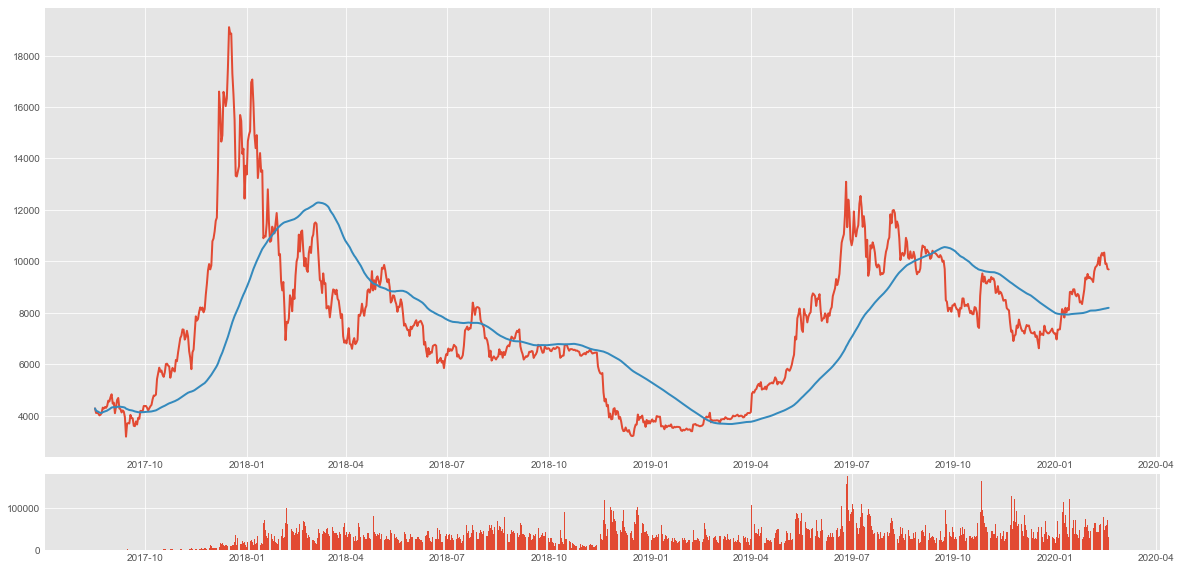

In [15]:
plt.figure(figsize=(20,10))
# Moving Average 100
df_btcusd['100MA'] = df_btcusd['Close'].rolling(window=100, min_periods=0).mean()

ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=1, colspan=1, sharex=ax1)

ax1.plot(df_btcusd.index, df_btcusd['Close'], df_btcusd['100MA'])
ax2.bar(df_btcusd.index, df_btcusd['Volume'])

plt.show()

In [16]:
df_ohlc = df_btcusd['Close'].resample('1d').ohlc()
df_volume = df_btcusd['Volume'].resample('1d').sum()
df_ohlc.head()

,open,high,low,close
Date,,,,
2017-08-17,4285.08,4285.08,4285.08,4285.08
2017-08-18,4108.37,4108.37,4108.37,4108.37
2017-08-19,4139.98,4139.98,4139.98,4139.98
2017-08-20,4086.29,4086.29,4086.29,4086.29
2017-08-21,4016.00,4016.00,4016.00,4016.00


In [17]:
df_ohlc.index = df_ohlc.index.map(mdates.date2num)
df_ohlc.head()

,open,high,low,close
736558.0,4285.08,4285.08,4285.08,4285.08
736559.0,4108.37,4108.37,4108.37,4108.37
736560.0,4139.98,4139.98,4139.98,4139.98
736561.0,4086.29,4086.29,4086.29,4086.29
736562.0,4016.00,4016.00,4016.00,4016.00


In [18]:
df_ohlc.reset_index(inplace=True)
df_ohlc.head()

,index,open,high,low,close
0,736558.0,4285.08,4285.08,4285.08,4285.08
1,736559.0,4108.37,4108.37,4108.37,4108.37
2,736560.0,4139.98,4139.98,4139.98,4139.98
3,736561.0,4086.29,4086.29,4086.29,4086.29
4,736562.0,4016.00,4016.00,4016.00,4016.00


In [19]:
df_ohlc.columns = [['Date', 'Open', 'High', 'Low', 'Close']]
df_ohlc.head()

,Date,Open,High,Low,Close
0,736558.0,4285.08,4285.08,4285.08,4285.08
1,736559.0,4108.37,4108.37,4108.37,4108.37
2,736560.0,4139.98,4139.98,4139.98,4139.98
3,736561.0,4086.29,4086.29,4086.29,4086.29
4,736562.0,4016.00,4016.00,4016.00,4016.00


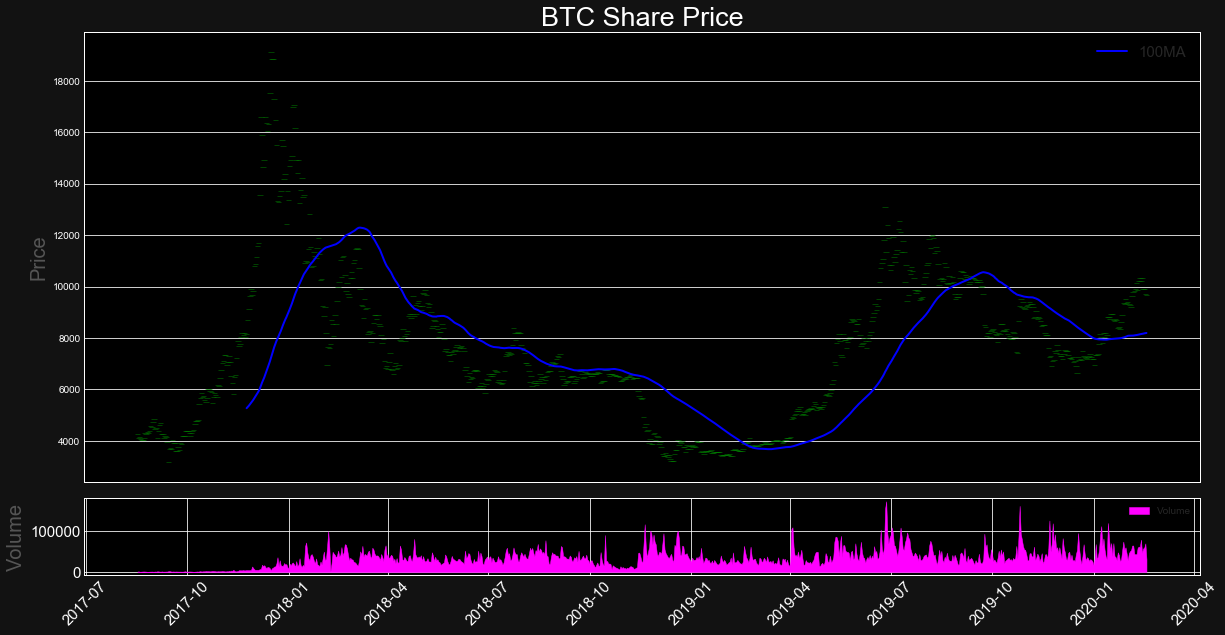

In [20]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=1, colspan=1, sharex=ax1)



candlestick_ohlc(ax1, df_ohlc.values, width=5, colorup='g', colordown='r')
ax1.grid(True)
ax1.set_axisbelow(True)
ax1.set_title('BTC Share Price', color='white', fontsize=27)
ax1.set_facecolor('black')
ax1.figure.set_facecolor('#121212')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')
ax1.axes.get_xaxis().set_visible(False)
ax1.set_ylabel('Price', fontsize = 20) 

ax1.plot(df_btcusd['Close'].rolling(window=100).mean(), color='b',  label='100MA')
ax1.legend(loc="upper right", fontsize=15)

plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
ax1.xaxis_date()


ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0, color = 'magenta',  label='Volume')
ax2.set_ylabel('Volume', fontsize = 20) 
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')
ax2.grid(True)
ax2.set_facecolor('black')
ax2.legend(loc="upper right", fontsize=15)
plt.legend()
plt.show()


# ARIMA

In [21]:
def evaluate_arima_model(X, arima_order):
    '''
    evaluate an ARIMA model for a given order (p,d,q)
    '''
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
 
def evaluate_models(dataset, p_values, d_values, q_values):
    '''
     evaluate combinations of p, d and q values for an ARIMA model
    '''
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [22]:
timeseries = df_btcusd.groupby('Date')['Close'].mean()
timeseries.head()

Date
2017-08-17    4285.08
2017-08-18    4108.37
2017-08-19    4139.98
2017-08-20    4086.29
2017-08-21    4016.00
Name: Close, dtype: float64

In [23]:
## evaluate parameters
#p_values = [0, 1, 2]
#d_values = range(0, 2)
#q_values = range(0, 2)
#warnings.filterwarnings("ignore")
#order = evaluate_models(timeseries.values, p_values, d_values, q_values)
#
#model= ARIMA(timeseries, order=order)
#model_fit= model.fit(disp=False)
#three_hours = model_fit.forecast(steps=3)

In [24]:
model = ARIMA(timeseries, order = (0,1,0))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  915
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -6780.100
Method:                           css   S.D. of innovations            399.817
Date:                Tue, 18 Feb 2020   AIC                          13564.199
Time:                        14:52:35   BIC                          13573.837
Sample:                    08-18-2017   HQIC                         13567.878
                         - 02-18-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9044     13.218      0.447      0.655     -20.001      31.810


C:\Users\luigi\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\luigi\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [25]:
forecast = model_fit.forecast(steps=50)

In [26]:
forecast

(array([9693.53442623, 9699.43885246, 9705.34327869, 9711.24770492,
        9717.15213115, 9723.05655738, 9728.96098361, 9734.86540984,
        9740.76983607, 9746.6742623 , 9752.57868852, 9758.48311475,
        9764.38754098, 9770.29196721, 9776.19639344, 9782.10081967,
        9788.0052459 , 9793.90967213, 9799.81409836, 9805.71852459,
        9811.62295082, 9817.52737705, 9823.43180328, 9829.33622951,
        9835.24065574, 9841.14508197, 9847.0495082 , 9852.95393443,
        9858.85836066, 9864.76278689, 9870.66721311, 9876.57163934,
        9882.47606557, 9888.3804918 , 9894.28491803, 9900.18934426,
        9906.09377049, 9911.99819672, 9917.90262295, 9923.80704918,
        9929.71147541, 9935.61590164, 9941.52032787, 9947.4247541 ,
        9953.32918033, 9959.23360656, 9965.13803279, 9971.04245902,
        9976.94688525, 9982.85131148]),
 array([ 399.81681219,  565.42635827,  692.50303244,  799.63362438,
         894.01757061,  979.34718045, 1057.81585504, 1130.85271653,
        

# random walk 0,1,0
past points don't affect present

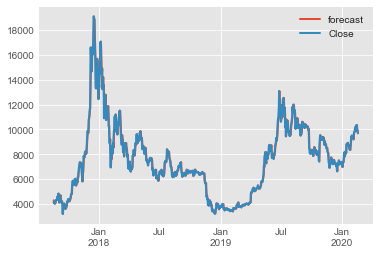

In [27]:
model_fit.plot_predict();

In [28]:
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel

In [29]:
def plotarima(n_periods, timeseries, automodel):
    # Forecast
    #fc, confint = automodel.predict(n_periods=n_periods, 
     #                               return_conf_int=True)
    # Weekly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=n_periods, freq="h")
    # Forecast series
    fc_series = pd.Series(forecast[0], index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(forecast[2][:,0], index=fc_ind)
    upper_series = pd.Series(forecast[2][:,1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(20,10))
    plt.plot(timeseries)
    plt.plot(fc_series, color="blue")
    plt.xlabel("date")
    plt.ylabel(timeseries.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25)
    plt.legend(("past", "forecast", "95% confidence interval"),  
               loc="upper left")
    plt.show();

In [30]:
automodel = arimamodel(timeseries)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=13567.394, BIC=13586.670, Fit time=0.337 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=13564.199, BIC=13573.837, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=13565.430, BIC=13579.887, Fit time=0.058 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=13565.447, BIC=13579.904, Fit time=0.065 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=13562.399, BIC=13567.218, Fit time=0.014 seconds
Total fit time: 0.510 seconds


### In statistics, the Bayesian information criterion (BIC) or Schwarz information criterion (also SIC, SBC, SBIC) is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred.

In [31]:
automodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  916
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6780.200
Date:                Tue, 18 Feb 2020   AIC                          13562.399
Time:                        14:52:42   BIC                          13567.218
Sample:                             0   HQIC                         13564.239
                                - 916                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.597e+05   2969.987     53.776      0.000    1.54e+05    1.66e+05
===================================================================================
Ljung-Box (Q):                      107.27   Jarque-Bera (JB):              4297.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

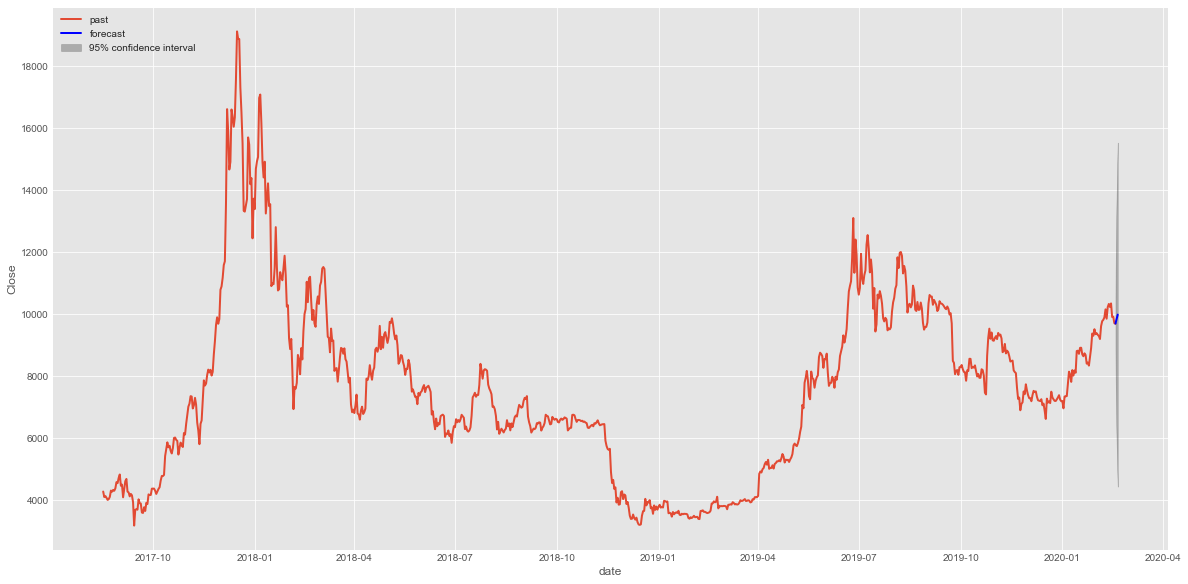

In [32]:
plotarima(50, timeseries, automodel);

# Get All Trading(currently) Symbols

In [33]:
def get_trading_symbols():
    
    response = requests.get('https://api.binance.com' + '/api/v1/exchangeInfo')
    data_symbols = json.loads(response.text)
    
    symbols = []

    for x in data_symbols['symbols']:
        if x['status'] == 'TRADING':
            symbols.append(x['symbol'])
            
    return symbols

In [34]:
symbols = get_trading_symbols()

In [35]:
len(symbols)

630

In [36]:
with open('crypto_tickers_daily.pickle', 'wb') as f:
    pickle.dump(symbols, f)

# Get Data for all the Symbols

In [31]:
def get_data_from_binance(reload_symbols=False, hourly=False):
    
    if hourly:
        cycles = 5
    else:
        cycles = 2
        
    if reload_symbols:
        symbols = get_trading_symbols()
    else:
        with open('crypto_tickers_daily.pickle', 'rb') as f:
            symbols = pickle.load(f)
            
    if not os.path.exists('crypto_dfs_ex'):
        os.makedirs('crypto_dfs_ex')
        
    df_main_crypto = pd.DataFrame()
    
    for symbol in symbols:
        
        print(symbol)
        
        if not os.path.exists('crypto_dfs_ex/{}.csv'.format(symbol)):
            
            
            df_crypto = pd.DataFrame()

            for x in range(cycles):

                if x == 0: 

                    response = requests.get(f'https://api.binance.com/api/v1/klines?symbol={symbol}&interval=1d')
                    data_symbol = json.loads(response.text)

                    # put in dataframe and drop columns we don't neeed
                    df = pd.DataFrame.from_dict(data_symbol)
                    df = df.drop(range(6, 12), axis=1)

                    # rename columns
                    col_names = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
                    df.columns = col_names

                    # transform values from strings to floats
                    for col in col_names[1:6]:
                        df[col] = df[col].astype(float)

                    df = df.sort_values(by='Time', ascending=False)

                    df_crypto = df_crypto.append(df)

                    timestamp = int(df.loc[0, 'Time'])
                    
                    if len(df) < 499:
                        
                        break

                else:

                    response = requests.get(f'https://api.binance.com/api/v1/klines?symbol={symbol}&interval=1d&endTime={timestamp}')
                    data_symbol = json.loads(response.text)

                    # put in dataframe and drop columns we don't neeed
                    df1 = pd.DataFrame.from_dict(data_symbol)
                    df1 = df1.drop(range(6, 12), axis=1)

                            # rename columns
                    col_names = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
                    df1.columns = col_names

                    # transform values from strings to floats
                    for col in col_names[1:6]:
                        df1[col] = df1[col].astype(float)

                    timestamp = int(df1.loc[0, 'Time'])

                    df1.drop(df1.head(1).index,inplace=True)

                    df1 = df1.sort_values(by='Time', ascending=False)

                    df_crypto = df_crypto.append(df1)

                    df_crypto.reset_index(drop = True, inplace = True)




            df_crypto['Date'] = pd.to_datetime(df_crypto['Time'], unit='ms')
            
            df_main_crypto = df_main_crypto.join(df_crypto)
            
            #df_crypto.to_csv('crypto_dfs_ex/{}.csv'.format(symbol))
            
        else:
            print('Already have {}'.format(symbol))
            
    return df_main_crypto

In [32]:
df_main_crypto = get_data_from_binance()

ETHBTC
Already have ETHBTC
LTCBTC
Already have LTCBTC
BNBBTC
Already have BNBBTC
NEOBTC
Already have NEOBTC
QTUMETH
Already have QTUMETH
EOSETH
Already have EOSETH
SNTETH
Already have SNTETH
BNTETH
Already have BNTETH
GASBTC
Already have GASBTC
BNBETH
Already have BNBETH
BTCUSDT
Already have BTCUSDT
ETHUSDT
Already have ETHUSDT
OAXETH
Already have OAXETH
DNTETH
Already have DNTETH
MCOETH
Already have MCOETH
MCOBTC
Already have MCOBTC
WTCBTC
Already have WTCBTC
WTCETH
Already have WTCETH
LRCBTC
Already have LRCBTC
LRCETH
Already have LRCETH
QTUMBTC
Already have QTUMBTC
YOYOBTC
Already have YOYOBTC
OMGBTC
Already have OMGBTC
OMGETH
Already have OMGETH
ZRXBTC
Already have ZRXBTC
ZRXETH
Already have ZRXETH
STRATBTC
Already have STRATBTC
STRATETH
Already have STRATETH
SNGLSBTC
Already have SNGLSBTC
BQXBTC
Already have BQXBTC
BQXETH
Already have BQXETH
KNCBTC
Already have KNCBTC
KNCETH
Already have KNCETH
FUNBTC
Already have FUNBTC
FUNETH
Already have FUNETH
SNMBTC
Already have SNMBTC
SNMETH

NEOPAX
Already have NEOPAX
NEOUSDC
Already have NEOUSDC
DASHBNB
Already have DASHBNB
DASHUSDT
Already have DASHUSDT
NANOUSDT
Already have NANOUSDT
OMGBNB
Already have OMGBNB
OMGUSDT
Already have OMGUSDT
THETAUSDT
Already have THETAUSDT
ENJUSDT
Already have ENJUSDT
MITHUSDT
Already have MITHUSDT
MATICBNB
Already have MATICBNB
MATICBTC
Already have MATICBTC
MATICUSDT
Already have MATICUSDT
ATOMBNB
Already have ATOMBNB
ATOMBTC
Already have ATOMBTC
ATOMUSDT
Already have ATOMUSDT
ATOMUSDC
Already have ATOMUSDC
ATOMTUSD
Already have ATOMTUSD
BATUSDC
Already have BATUSDC
BATPAX
Already have BATPAX
BATTUSD
Already have BATTUSD
PHBBNB
Already have PHBBNB
PHBBTC
Already have PHBBTC
PHBTUSD
Already have PHBTUSD
TFUELBNB
Already have TFUELBNB
TFUELBTC
Already have TFUELBTC
TFUELUSDT
Already have TFUELUSDT
ONEBNB
Already have ONEBNB
ONEBTC
Already have ONEBTC
ONEUSDT
Already have ONEUSDT
ONEUSDC
Already have ONEUSDC
FTMBNB
Already have FTMBNB
FTMBTC
Already have FTMBTC
FTMUSDT
Already have FTMUSDT


In [33]:
df_main_crypto

""


In [4]:
import pandas as pd
import pickle

In [9]:
df =pd.read_csv(f'crypto_dfs_daily/ZRXBTC.csv',  index_col=0)
df.head()

,Time,Open,High,Low,Close,Volume,Date
0,1581897600000,0.000030,0.000030,0.000027,0.000030,12447651.0,2020-02-17
1,1581811200000,0.000032,0.000033,0.000028,0.000030,18301190.0,2020-02-16
2,1581724800000,0.000033,0.000035,0.000030,0.000032,18437496.0,2020-02-15
3,1581638400000,0.000031,0.000034,0.000031,0.000033,21644328.0,2020-02-14
4,1581552000000,0.000030,0.000033,0.000028,0.000031,25097391.0,2020-02-13


In [10]:
df.shape

(888, 7)

In [11]:
 df.set_index('Date', inplace=True)
        
      

In [14]:
df.rename(columns={'Close' : 'zrx'}, inplace=True)
df.drop(['Time','Open','High','Low','Volume'], 1, inplace=True)

In [15]:
df

,zrx
Date,
2020-02-17,0.000030
2020-02-16,0.000030
2020-02-15,0.000032
2020-02-14,0.000033
2020-02-13,0.000031
2020-02-12,0.000030
2020-02-11,0.000030
2020-02-10,0.000029
2020-02-09,0.000029


In [16]:
main_df = pd.DataFrame()
main_df = main_df.join(df)

NameError: name 'main_df' is not defined

In [19]:
def compile_data():
    with open('crypto_tickers_daily.pickle', 'rb') as f:
        symbols = pickle.load(f)
    
    main_df = pd.DataFrame()
    
    for count, symbol in enumerate(symbols):
        
        print(symbol)
        df =pd.read_csv(f'crypto_dfs_daily/{symbol}.csv',  index_col=0)
        df.set_index('Date', inplace=True)
        
        df.rename(columns={'Close' : symbol}, inplace=True)
        df.drop(['Time','Open','High','Low','Volume'], 1, inplace=True)
        

        
        if main_df.empty:
                main_df = df

        else:
             main_df = main_df.join(df)

        if count % 10 == 0:
            print(count)
        
        main_df.to_csv('500crypto_joined_daily.csv')    
        
    print(main_df.head())    
        #main_df.set_index('Date', inplace=True)
    #main_df.to_csv('500crypto_joined_daily.csv')
    return main_df

In [20]:
main_df = compile_data()

ETHBTC
0
LTCBTC
BNBBTC
NEOBTC
QTUMETH
EOSETH
SNTETH
BNTETH
GASBTC
BNBETH
BTCUSDT
10
ETHUSDT
OAXETH
DNTETH
MCOETH
MCOBTC
WTCBTC
WTCETH
LRCBTC
LRCETH
QTUMBTC
20
YOYOBTC
OMGBTC
OMGETH
ZRXBTC


MemoryError: 

In [51]:
main_df

,ETHBTC,LTCBTC,BNBBTC,NEOBTC,QTUMETH,EOSETH,SNTETH,BNTETH,GASBTC,BNBETH,BTCUSDT,ETHUSDT,OAXETH,DNTETH,MCOETH,MCOBTC,WTCBTC,WTCETH,LRCBTC,LRCETH
Date,,,,,,,,,,,,,,,,,,,,
2017-07-15,0.087635,0.019504,0.000038,0.002514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-16,0.082241,0.021418,0.000039,0.002638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-17,0.087537,0.019133,0.000041,0.002666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-18,0.107732,0.019010,0.000037,0.002643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-19,0.086853,0.017929,0.000048,0.002580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-20,0.080509,0.015674,0.000041,0.002578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-21,0.081581,0.017004,0.000042,0.002762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-22,0.082474,0.016506,0.000042,0.003124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-23,0.083533,0.016355,0.000043,0.003261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
main_df.duplicated().any()

True

# Find Relationship with different Cryptocurrencies

In [ ]:
df = pd.read_csv('500crypto_joined_close.csv')
corrs = df.corr()
corrs

In [ ]:
corrs.index

In [ ]:
def visualize_data():
    df = pd.read_csv('500crypto_joined_close.csv')
    corrs = df.corr()

    fig = go.Figure(data=go.Heatmap(
                    z=corrs.values,
                    x=list(corrs.columns),
                    y=list(corrs.index),
                    showscale=True,
                    colorscale='Inferno',
                    hoverongaps = False))
    fig.show()

In [ ]:
visualize_data()

In [ ]:
main_df['ETHBTC'].iplot(mode='lines+text',
                        xTitle='Time',
                        yTitle='Price', 
                        title='Hourly ETHBTC Close',
                        opacity=0.8)

# Preprocess data for Machine Learning

Through our heatmap we saw that there's correlation in terms of price between different cryptocurrencies.

The question is, can we get a Machine to recognize those relationship?

Can we take in account tthe movement of all the companies and get an edge doing it?

In [ ]:
def process_data_for_labels(symbol):
    hours = 12
    df = pd.read_csv('500crypto_joined_close.csv', index_col=0)
    symbols = df.columns.values.tolist()
    
    for i in range(1, hours+1):
        df[f'{symbol}_{i}h'] = (df[symbol].shift(-i) - df[symbol]) / df[symbol]
        
    df.fillna(0, inplace=True)
    
    return hours, symbols, df

In [ ]:
process_data_for_labels('ETHBTC')

# Create labels buy, hold, sell for machine learning

Create buy, hold, sell labels based on a % change.

In [ ]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    change_perc = 0.02
    for col in cols:
        if col > change_perc:
            return 1
        if col < -change_perc:
            return -1
    return 0

In [ ]:
def extract_feature_sets(symbol):
    
    hours, symbols, df = process_data_for_labels(symbol)
    
    df[f'{symbol}_target'] = list(map(buy_sell_hold, *[df[f'{symbol}_{i}h'] for i in range(1, hours+1)]))
    
    labels = df[f'{symbol}_target'].values.tolist()
    str_labels = [str(i) for i in labels]
    print('Data Spread: ', Counter(str_labels))
    
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    # Create Feature Sets
    
    # Percentage change in data for all of the cryptocurrencies including company in question
    df_vals = df[[symbol for symbol in symbols]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X = df_vals.values
    y = labels
    
    return X, y, df

In [ ]:
X, y, df = extract_feature_sets('BTCUSDT')

In [ ]:
X.shape

In [ ]:
def do_machine_learning(symbol):
    
    X, y, df = extract_feature_sets(symbol)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)
    
    p1 = Pipeline([['ran_for_clf', RandomForestClassifier(random_state=123)]])
    p2 = Pipeline([['boost_clf', AdaBoostClassifier(random_state=123)]])
    p3 = Pipeline([['log_clf', LogisticRegression(random_state=123)]])
    p4 = Pipeline([['vot_clf', VotingClassifier(estimators=[("p1",p1), ("p2",p2), ("p3",p3)])]])
    p4.get_params()
    
    p4.fit(X_train, y_train)
    confidence = p4.score(X_test, y_test)
    print('Accuracy: ', confidence)
    predictions = p4.predict(X_test)
    print('-----------')
    print('Predicted Data Spread: ', Counter(predictions))

In [ ]:
do_machine_learning('BTCUSDT')

In [ ]:
do_machine_learning('ETHBTC')

In [ ]:
#pipe_svm = Pipeline([('pca', PCA(n_components=27)),
#        ('clf', svm.SVC(random_state=123))])
#        
#pipe_tree = Pipeline([('pca', PCA(n_components=27)),
#        ('clf', tree.DecisionTreeClassifier(random_state=123))])
#
#pipe_rf = Pipeline([('pca', PCA(n_components=27)),
#        ('clf', RandomForestClassifier(random_state=123))])
#
## List of pipelines, List of pipeline names
#pipelines = [pipe_svm, pipe_tree, pipe_rf]
#pipeline_names = ['Support Vector Machine','Decision Tree','Random Forest']
#
## Loop to fit each of the three pipelines
#for pipe in pipelines:
#    print(pipe)
#    pipe.fit(X_train, y_train)
#
## Compare accuracies
#for index, val in enumerate(pipelines):
#    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

In [ ]:
def conf_matrix(y_test, y_pred):
    
    labels = ['sell', 'hold', 'buy']
    cnf_matrix = confusion_matrix(y_test, y_pred, labels)
    
    plt.figure(figsize = (12,8))
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues, aspect='auto') #Create the basic matrix.
    
    #Add title and Axis Labels
    plt.title('Confusion Matrix', fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    
    #Add appropriate Axis Scales
    class_names = set(y) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, fontsize=20)
    plt.yticks(tick_marks, class_names, fontsize=20)
    
    #Add Labels to Each Cell
    thresh = cnf_matrix.max() / 2. #Used for text coloring below
    #Here we iterate through the confusion matrix and append labels to our visualization.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment="center",
                     fontsize =18,
                     color="white" if cnf_matrix[i, j] > thresh else "black")
    
    #Add a Side Bar Legend Showing Colors
    plt.colorbar();

In [ ]:
 def log_regr(X, y):
    ''' train LogRegr Classifier and calculate score on Train and Test data
    
        Args: 
            X: model features (df)
            y: model target feature (df)
            
        Returns: 
            clf: fitted instance of LogReg classifier
            y_pred: prediction made on X_test data (np array)
            train_score_logreg: score for Train data (float)
            test_score_logreg: score for Test data (float)
    '''
    # Train a LogRegr classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate Score
    train_score_logreg = clf.score(X_train, y_train)
    test_score_logreg = clf.score(X_test, y_test)
    print("LogReg Train score: ", train_score_logreg)
    print("LogReg Test score: ", test_score_logreg)
    print("\n")
    
    return clf, train_score_logreg, test_score_logreg

In [ ]:
 def dec_tree(X, y):
    ''' train DecTree Classifier using GridSearch and calculate score on Train and Test data
    
        Args: 
            X: model features (df)
            y: model target feature (df)
            
        Returns: 
            clf_dec_tree: fitted instance of DecisionTree classifier
            dt_grid_search: fitted instance of GridSearch classifier
            dt_gs_train_score: score for Train data (float)
            dt_gs_testing_score: score for Test data (float)
    '''
    # Train a DT classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    clf_dec_tree = DecisionTreeClassifier(random_state=10)  
    clf_dec_tree.fit(X_train, y_train)  
    
    # GridSearch
    dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
    }
    
    # Instantiate GridSearchCV
    dt_grid_search = GridSearchCV(clf_dec_tree, dt_param_grid, cv=3, return_train_score=True)
    dt_grid_search.fit(X_train, y_train)
    y_pred = dt_grid_search.predict(X_test)
    
    # Calculate Score
    dt_gs_train_score = dt_grid_search.score(X_train, y_train)
    dt_gs_testing_score = dt_grid_search.score(X_test, y_test)
    print("DecTree GridSearch Train score: ", dt_gs_train_score)
    print("DecTree GridSearch Test score: ", dt_gs_testing_score)
    print(f"Optimal Parameters: {dt_grid_search.best_params_}")
    print("\n")
    
    
    return clf_dec_tree, dt_grid_search, dt_gs_train_score, dt_gs_testing_score, y_test, y_pred

In [ ]:
 def rand_for(X, y):
    ''' train RandFor Classifier using GridSearch, calculate score on Train and Test data and 
        Visualize feature importance
    
        Args: 
            X: model features (df)
            y: model target feature (df)
            
        Returns: 
            rf_grid_search: fitted instance of GridSearch classifier
            rf_gs_train_score: score for Train data (float)
            rf_gs_testing_score: score for Test data (float)
            rf_gs_f1_score: f1 score
    '''
    # Train a RF classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    clf_rand_for = RandomForestClassifier(random_state=10)  
    clf_rand_for.fit(X_train, y_train)  
    
    # GridSearch
    rf_param_grid = {
    'n_estimators': [10, 30],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 3, 6]
    }
    
    # Instantiate GridSearchCV
    rf_grid_search = GridSearchCV(clf_rand_for, rf_param_grid, cv=3)
    rf_grid_search.fit(X_train, y_train)
    
    # Cross validation
    #rf_cv_score = cross_val_score(rf_grid_search, X_train, y_train, cv=5)
    #mean_rf_cv_score = np.mean(rf_cv_score)
    
    # Calculate Score
    rf_gs_train_score = rf_grid_search.score(X_train, y_train)
    rf_gs_testing_score = rf_grid_search.score(X_test, y_test)
    y_pred_gs = rf_grid_search.predict(X_test)
    
    print("RandFor GridSearch Train score: ", rf_gs_train_score)
    print("RandFor GridSearch Test score: ", rf_gs_testing_score)
    #print("RandFor GridSearch Cross Val score: ", rf_gs_testing_score)
    print(f"Optimal Parameters: {rf_grid_search.best_params_}")
    print("\n")
    
    return  clf_rand_for, rf_grid_search, rf_gs_train_score, rf_gs_testing_score

In [ ]:
X, y, df = extract_feature_sets('BTCUSDT')

In [ ]:
def machine_learning(X, y):
    ''' runs log_regr, dec_tree and rand_for functions
    
        print Confusion Matrices for Logistic Regression and Random Forest
    
        Args: 
            X: model features (df)
            y: model target feature (df)
        
    '''    
    clf, train_score_logreg, test_score_logreg = log_regr(X, y)
    clf_dec_tree, dt_grid_search, dt_gs_train_score, dt_gs_testing_score, y_test, y_pred = dec_tree(X, y)
    #clf_rand_for, rf_grid_search, rf_gs_train_score, rf_gs_testing_score= rand_for(X, y)
    
    #Create and print a confusion matrix 
    conf_matrix(y_test, y_pred);

In [ ]:
machine_learning(X, y)

In [ ]:
#with open('regression_model.pickle', 'wb') as f:
#    pickle.dump(clf, f)

# try daily data instead of hour

# before Feature importance on ran for and after weight_class inside ran for classifier

# Create func to compare highest and lowe correlations
